## Import libraries


In [12]:
import argparse
import concurrent.futures
import json
import os
import warnings
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, timedelta
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import weibull_min
from shapely.geometry import Point
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

warnings.filterwarnings("ignore")

WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/"
os.chdir(WORK_DIR)
MAIN_DATA_DIR = "/beegfs/halder/DATA/"
PHENO_DATA_DIR = "/beegfs/halder/GITHUB/RESEARCH/land-surface-phenology/data/phenology_processed_(DE)_all"
DWD_DATA_DIR = (
    "/beegfs/common/data/climate/dwd/csvs/germany_ubn_1951-01-01_to_2024-08-30"
)
OUT_DIR = os.path.join(WORK_DIR, "output")

In [17]:
# Parameters
CROP = "winter_wheat"

## Read the dataset


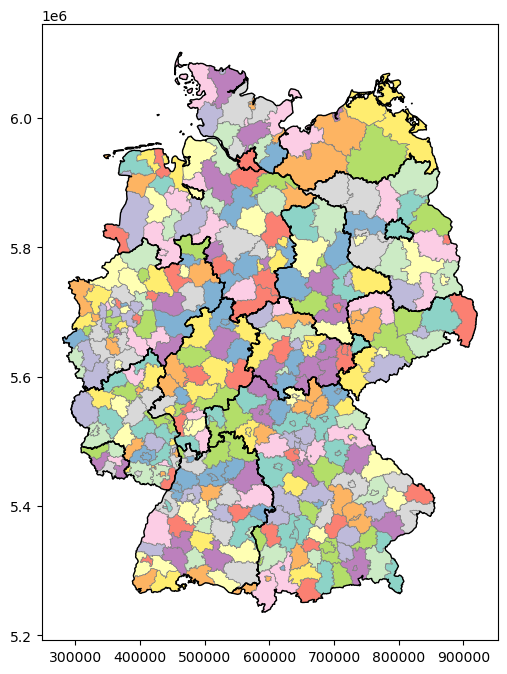

(16, 6) (400, 6)


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,geometry
0,DE11B,3,DE,Main-Tauber-Kreis,Main-Tauber-Kreis,"POLYGON ((546793.49 5514433.543, 546531.283 55..."
1,DE11C,3,DE,Heidenheim,Heidenheim,"MULTIPOLYGON (((585299.35 5401977.751, 585395...."
2,DE11D,3,DE,Ostalbkreis,Ostalbkreis,"MULTIPOLYGON (((591812.28 5434830.278, 591515...."
3,DE121,3,DE,"Baden-Baden, Stadtkreis","Baden-Baden, Stadtkreis","MULTIPOLYGON (((440009.175 5410196.803, 441490..."
4,DE122,3,DE,"Karlsruhe, Stadtkreis","Karlsruhe, Stadtkreis","POLYGON ((458238.847 5435551.545, 459823.952 5..."


In [9]:
# Read the NUTS1 and NUTS3 shapefile for DE
de_nuts1_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts1_gdf = de_nuts1_gdf[
    de_nuts1_gdf["LEVL_CODE"] == 1
]  # filter only NUT1 level code
de_nuts1_gdf.rename(
    columns={"NUTS_ID": "STATE_ID", "NUTS_NAME": "STATE_NAME"}, inplace=True
)

de_nuts3_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts3_gdf = de_nuts3_gdf[
    de_nuts3_gdf["LEVL_CODE"] == 3
]  # filter only NUT3 level code

de_nuts1_gdf.to_crs(crs="EPSG:25832", inplace=True)
de_nuts3_gdf.to_crs(crs="EPSG:25832", inplace=True)

fig, ax = plt.subplots(figsize=(8, 8))
de_nuts3_gdf.plot(
    ax=ax,
    column="NUTS_NAME",
    cmap="Set3",
    edgecolor="grey",
    linewidth=0.5,
    label="NUTS3",
)
de_nuts1_gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, label="NUTS1")
plt.show()

print(de_nuts1_gdf.shape, de_nuts3_gdf.shape)
de_nuts3_gdf.head()

In [10]:
# Specify the DE DWD grip file path
DE_DWD_json_path = os.path.join(
    MAIN_DATA_DIR, "DE_DWD_Lat_Lon", "latlon_to_rowcol.json"
)

with open(DE_DWD_json_path) as f:
    data = json.load(f)

# Convert data to GeoDataFrame
records = []
for coord, index in data:
    lat, lon = coord
    row, col = index
    point = Point(lon, lat)
    records.append({"row": row, "col": col, "geometry": point})

latlon_gdf = gpd.GeoDataFrame(records, geometry="geometry", crs="EPSG:4326")
latlon_gdf.to_crs(crs="EPSG:25832", inplace=True)

latlon_gdf = gpd.sjoin(
    left_df=latlon_gdf,
    right_df=de_nuts3_gdf[["NUTS_ID", "NUTS_NAME", "geometry"]],
    how="inner",
    predicate="intersects",
).drop(columns="index_right")

latlon_gdf["rowcol"] = list(zip(latlon_gdf["row"], latlon_gdf["col"]))

print(latlon_gdf.shape)
latlon_gdf.head()

(356838, 6)


,row,col,geometry,NUTS_ID,NUTS_NAME,rowcol
1,0,182,POINT (462860.261 6100999.898),DEF07,Nordfriesland,"(0, 182)"
3,1,181,POINT (461860.651 6100000.306),DEF07,Nordfriesland,"(1, 181)"
4,2,180,POINT (460861.041 6099000.714),DEF07,Nordfriesland,"(2, 180)"
6,3,180,POINT (460861.032 6098001.113),DEF07,Nordfriesland,"(3, 180)"
7,3,181,POINT (461860.633 6098001.104),DEF07,Nordfriesland,"(3, 181)"


## Process the phenology data


In [11]:
def get_start_end_doy(data_path):
    """
    Get the start DOY, end DOY, and full DOY window for sowing–harvest period.

    Parameters
    ----------
    data_path : str
        Path to a CSV file with columns 'sowing_date', 'flowering_date', 'maturity_date'.

    Returns
    -------
    dict
        {
            'sow_month': int,             # Sow month
            'harvest_month': int          # Harvest month
            'sow_month_start_doy': int,   # DOY of the first sowing month (day 1 of month)
            'harvest_month_end_doy': int, # DOY of the last harvest month (day 31 of month)
            'window_length_in_days': int, # Total days in the sowing–harvest window
            'window_doys': list[int]      # List of DOYs in the window
        }
    """
    REF_YEAR = 1970  # Non-leap reference year for DOY calculation

    # Read phenology data
    phenology_df = pd.read_csv(data_path)

    # Get earliest sowing month and latest harvest month
    sow_month = (
        pd.to_datetime(phenology_df["sowing_date"]).dt.month.median().astype(int)
    )
    harvest_month = (
        pd.to_datetime(phenology_df["maturity_date"]).dt.month.median().astype(int)
    )
    print(sow_month, harvest_month)
    # Convert months to DOY
    sow_doy = datetime(REF_YEAR, sow_month, 1).timetuple().tm_yday

    try:
        harvest_doy = datetime(REF_YEAR, harvest_month, 31).timetuple().tm_yday
    except:
        harvest_doy = datetime(REF_YEAR, harvest_month, 30).timetuple().tm_yday

    # Build DOY window, handling year wrap-around
    if harvest_doy < sow_doy:
        window_doys = list(range(sow_doy, 366)) + list(range(1, harvest_doy + 1))
    else:
        window_doys = list(range(sow_doy, harvest_doy + 1))

    return {
        "sow_month": sow_month,
        "harvest_month": harvest_month,
        "sow_month_start_doy": sow_doy,
        "harvest_month_end_doy": harvest_doy,
        "window_length_in_days": len(window_doys),
        "window_doys": window_doys,
    }


# Read the phenology data
phenology_summary = get_start_end_doy(
    os.path.join(
        "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/data/processed",
        CROP,
        f"{CROP}_phenology.csv",
    )
)
print("Sow Month:", phenology_summary["sow_month"])
print("Harvest Month:", phenology_summary["harvest_month"])
print("Sow Month Start DOY:", phenology_summary["sow_month_start_doy"])
print("Harvest Month End DOY:", phenology_summary["harvest_month_end_doy"])
print("Window Length in Days:", phenology_summary["window_length_in_days"])

10 8
Sow Month: 10
Harvest Month: 8
Sow Month Start DOY: 274
Harvest Month End DOY: 243
Window Length in Days: 335


In [6]:
# Read the phenology data
phenology_df = pd.read_csv(
    os.path.join(
        "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/data/processed",
        CROP,
        f"{CROP}_phenology.csv",
    )
)
phenology_df = phenology_df[phenology_df["harvest_year"] >= 2000]

for date_col in ["sowing_date", "flowering_date", "maturity_date"]:
    event = date_col.split("_")[0]
    phenology_df[date_col] = pd.to_datetime(phenology_df[date_col], format="%Y-%m-%d")
    phenology_df[f"{event}_DOY"] = phenology_df[date_col].dt.dayofyear

sow_year = phenology_df["sowing_date"].dt.year
start_month = phenology_summary["sow_month"] - 3  # starting 3 months advance
start_date = pd.to_datetime(
    sow_year.astype(str) + "-" + start_month.astype(str) + "-01"
)
phenology_df["start_date"] = start_date

harvest_year = phenology_df["maturity_date"].dt.year
end_month = phenology_summary["harvest_month"]
end_date = pd.to_datetime(
    harvest_year.astype(str) + "-" + end_month.astype(str) + "-01"
) + pd.offsets.MonthEnd(0)
phenology_df["end_date"] = end_date


def extend_phenology(df, target_year=2024):
    extended_rows = []

    # Loop through each NUTS independently
    for nuts_id, group in df.groupby("NUTS_ID"):
        years_present = set(group["harvest_year"])
        min_year = group["harvest_year"].min()
        max_year = max(group["harvest_year"].max(), target_year)
        all_years = set(range(min_year, max_year + 1))
        missing_years = sorted(all_years - years_present)

        # Use the latest available record for that NUTS as the template
        for year in missing_years:
            # Find the closest previous year available as template
            template_years = group[group["harvest_year"] <= year]
            if template_years.empty:
                continue  # skip if no template available
            template_row = template_years.iloc[-1]

            new_row = template_row.copy()
            new_row["harvest_year"] = year

            def shift_date(date_str, offset):
                d = pd.to_datetime(date_str)
                return (d + pd.DateOffset(years=offset)).strftime("%Y-%m-%d")

            offset = year - template_row["harvest_year"]
            new_row["sowing_date"] = shift_date(template_row["sowing_date"], offset)
            new_row["emergence_date"] = shift_date(
                template_row["emergence_date"], offset
            )
            new_row["flowering_date"] = shift_date(
                template_row["flowering_date"], offset
            )
            new_row["maturity_date"] = shift_date(template_row["maturity_date"], offset)
            new_row["start_date"] = shift_date(template_row["start_date"], offset)
            new_row["end_date"] = shift_date(template_row["end_date"], offset)

            extended_rows.append(new_row)

    # Combine original and extended data
    extended_df = pd.concat([df, pd.DataFrame(extended_rows)], ignore_index=True)
    extended_df = extended_df.sort_values(by=["NUTS_ID", "harvest_year"]).reset_index(
        drop=True
    )

    return extended_df


phenology_df = extend_phenology(phenology_df, target_year=2024)
print(phenology_df.shape)
phenology_df.head()

(8319, 18)


,harvest_year,NUTS_ID,NUTS_NAME,STATE_ID,STATE_NAME,sowing_date,sowing_doy,emergence_date,emergence_doy,flowering_date,flowering_doy,maturity_date,maturity_doy,sowing_DOY,flowering_DOY,maturity_DOY,start_date,end_date
0,2000,DE111,"Stuttgart, Stadtkreis",DE1,Baden-Württemberg,1999-10-11 00:00:00,284,1999-10-25,298,2000-05-28 00:00:00,148,2000-08-12 00:00:00,224,284,149,225,1999-07-01 00:00:00,2000-08-31 00:00:00
1,2001,DE111,"Stuttgart, Stadtkreis",DE1,Baden-Württemberg,2000-10-19 00:00:00,292,2000-10-30,303,2001-05-29 00:00:00,149,2001-08-02 00:00:00,214,293,149,214,2000-07-01 00:00:00,2001-08-31 00:00:00
2,2002,DE111,"Stuttgart, Stadtkreis",DE1,Baden-Württemberg,2001-10-10 00:00:00,283,2001-10-24,297,2002-05-29 00:00:00,149,2002-08-20 00:00:00,232,283,149,232,2001-07-01 00:00:00,2002-08-31 00:00:00
3,2003,DE111,"Stuttgart, Stadtkreis",DE1,Baden-Württemberg,2002-10-15 00:00:00,288,2002-10-29,302,2003-05-29 00:00:00,149,2003-07-27 00:00:00,208,288,149,208,2002-07-01 00:00:00,2003-08-31 00:00:00
4,2004,DE111,"Stuttgart, Stadtkreis",DE1,Baden-Württemberg,2003-10-09 00:00:00,282,2003-10-20,293,2004-05-24 00:00:00,144,2004-08-05 00:00:00,217,282,145,218,2003-07-01 00:00:00,2004-08-31 00:00:00


## Extract climate data


In [7]:
def get_phenology(nuts_id, year):
    subset = phenology_df[
        (phenology_df["NUTS_ID"] == nuts_id) & (phenology_df["harvest_year"] == year)
    ]
    if subset.empty:
        return None
    return subset.iloc[0].to_dict()


def extract_climate_data_by_nuts(nuts_id, out_dir):
    row_cols = np.array(latlon_gdf.loc[latlon_gdf["NUTS_ID"] == nuts_id, "rowcol"])

    file_paths = []
    for row, col in row_cols:
        fpath = os.path.join(
            DWD_DATA_DIR, str(row), f"daily_mean_RES1_C{col}R{row}.csv.gz"
        )
        if os.path.exists(fpath):
            file_paths.append(fpath)

    if not file_paths:
        print(f"No climate files found for hex ID {nuts_id}")
        return

    column_names = {
        "Date": "date",
        "TempMin": "tmin",
        "TempMax": "tmax",
        "Precipitation": "prec",
        "Radiation": "rad",
        "SunshineDuration": "sun_dur",
        "SoilMoisture": "soil_moist",
        "SoilTemperature": "soil_temp",
        "RefETcalc": "et0",
        "RefETdwd": "et0_dwd",
        "RelHumCalc": "rh",
    }

    clim_dfs = []
    for f in file_paths:
        try:
            df = pd.read_csv(
                f,
                delimiter="\t",
                usecols=[
                    "Date",
                    "Precipitation",
                    "TempMin",
                    "TempMax",
                    "Radiation",
                    "SunshineDuration",
                    "SoilMoisture",
                    "SoilTemperature",
                    "Windspeed",
                    "RefETcalc",
                    "RefETdwd",
                    "RelHumCalc",
                ],
            )
            df.rename(columns=column_names, inplace=True)
            df = df[list(column_names.values())]
            df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

            # Saturation vapor pressure (kPa)
            df["es_tmin"] = 0.6108 * np.exp((17.27 * df["tmin"]) / (df["tmin"] + 237.3))
            df["es_tmax"] = 0.6108 * np.exp((17.27 * df["tmax"]) / (df["tmax"] + 237.3))
            df["es"] = (df["es_tmin"] + df["es_tmax"]) / 2
            df["ea"] = (df["rh"] / 100) * df["es"]
            df["vpd"] = df["es"] - df["ea"]

            # Average temperature and water balance
            df["tavg"] = (df["tmax"] + df["tmin"]) / 2
            df["cwb"] = df["prec"] - df["et0"]
            df["rad"] = df["rad"] / 1000  # kJ/m²·day to MJ/m²·day

            clim_dfs.append(df)

        except Exception as e:
            print(f"Error reading file {f}: {e}")
            continue

    # Merge and aggregate
    clim_merged = pd.concat(clim_dfs).groupby("date").mean().reset_index()
    clim_merged = clim_merged[
        [
            "date",
            "tmin",
            "tmax",
            "tavg",
            "prec",
            "rad",
            "sun_dur",
            "soil_moist",
            "soil_temp",
            "et0",
            "vpd",
            "cwb",
        ]
    ]
    clim_merged.iloc[:, 1:] = clim_merged.iloc[:, 1:].round(3)

    # Loop over years using phenology windows
    for year in sorted(phenology_df["harvest_year"].unique()):
        pheno = get_phenology(nuts_id, year)
        if pheno is None:
            continue

        start_date = pheno["start_date"]
        end_date = pheno["end_date"]

        clim_year = clim_merged[
            (clim_merged["date"] >= start_date) & (clim_merged["date"] <= end_date)
        ].copy()

        if clim_year.empty:
            continue

        save_path = os.path.join(out_dir, f"{nuts_id}_{year}.csv")
        clim_year.to_csv(save_path, index=False)

In [ ]:
OUT_DIR_CLIMATE = os.path.join(WORK_DIR, "data", "interim", "climate", f"{CROP}")

if os.path.exists(OUT_DIR_CLIMATE):
    print("Directory already exists!")
else:
    os.makedirs(OUT_DIR_CLIMATE, exist_ok=True)
    print("Directory successfully created!")

# Prepare all hex_ids to be processed
nuts_ids = latlon_gdf["NUTS_ID"].unique()


# Function to wrap
def wrapper(nuts_id):
    extract_climate_data_by_nuts(nuts_id, OUT_DIR_CLIMATE)


# Use tqdm's process_map instead of executor.map
process_map(wrapper, nuts_ids, max_workers=10, chunksize=1)
print("Climate data computation complete!")

Directory already exists!


  0%|          | 0/400 [00:00<?, ?it/s]